In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import math
import torch_geometric as pyg
from torch_geometric import EdgeIndex
import random
import networkx as nx
import heapq
from tqdm import tqdm
from enum import Enum
import functools

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_device(device)
torch.set_default_dtype(torch.float32)

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

/home/beni/windfarm_data_imputation/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_df = pd.read_csv("../data/processed_data.csv")
position_df = pd.read_csv("../data/turbines.csv")

# Zero-indexed makes indexing easier
data_df["TurbID"] -= 1
position_df["TurbID"] -= 1
data_df["Day"] -= 1

# Number of rows in data
R = len(data_df)

# Number of turbines
N = len(position_df)

# For ease-of-access, normalize turbine coordinates to [0,1] and put them in a dictionary
positions_by_id = {}
minX = position_df["x"].min()
maxX = position_df["x"].max()
minY = position_df["y"].min()
maxY = position_df["y"].max()
for _, row in position_df.iterrows():
    norm_x = (row["x"] - minX) / (maxX - minX)
    norm_y = (row["y"] - minY) / (maxY - minY)
    positions_by_id[row["TurbID"].astype(int)] = (norm_x, norm_y)

# Calculate timestamps in the range [0,T) where T is the total number of unique timestamps
time_minutes = data_df["Tmstamp"].str.split(":", expand=True).astype(int)
total_minutes_of_day = time_minutes[0] * 60 + time_minutes[1]
integral_timestamps = (data_df["Day"] * 144 + (total_minutes_of_day // 10)).to_numpy(dtype=int)
T = integral_timestamps.max() + 1

# Discard useless columns, extract features from dataframe, normalize all features to [0,1]
data_df.drop(columns=["Day", "Tmstamp", "datetime", "P_norm"], inplace=True)
nodes = np.array(data_df["TurbID"], dtype=int)
vals = data_df.values.astype(np.float32)
mins = np.array(list(data_df.min(axis=0, skipna=True))).reshape((1, -1))
maxs = np.array(data_df.max(axis=0, skipna=True)).reshape((1, -1))
vals = (vals - mins) / (maxs - mins)

# F is the number of features (10)
# Features: [Wspd, Wdir, Etmp, Itmp, Ndir, Pab1, Pab2, Pab3, Prtv, Patv[] (normalized to [0,1]!)
F = vals.shape[1]-1

# Construct data tensor, replace NaNs with -100
X = torch.zeros((T, N, F), dtype=torch.float32, device=device, requires_grad=False)
display(data_df)
X[integral_timestamps, nodes] = torch.tensor(np.nan_to_num(vals[:,1:], nan=-100), dtype=torch.float32, requires_grad=False)

# Data tensor has shape (T,N,F)
print(X.shape)

,TurbID,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,0,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
1,0,6.27,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,-0.24,509.76
2,0,6.42,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,-0.26,542.53
3,0,6.25,0.89,30.49,41.38,20.91,1.00,1.00,1.00,-0.23,509.36
4,0,6.10,-1.03,30.47,41.22,20.91,1.00,1.00,1.00,-0.27,482.21
...,...,...,...,...,...,...,...,...,...,...,...
4657123,133,7.79,2.80,-0.07,3.95,216.51,6.03,6.03,6.03,-111.69,601.44
4657124,133,8.06,4.39,0.23,3.94,216.51,5.81,5.81,5.81,-72.67,673.79
4657125,133,8.08,2.28,-0.16,4.15,216.51,0.68,0.68,0.68,-118.70,999.36
4657126,133,8.46,0.80,-0.14,4.32,216.51,0.02,0.02,0.02,-58.12,1100.89


torch.Size([35280, 134, 10])


In [3]:
SZ = 4
L = 1
while SZ // 2 < T:
    SZ *= 2
    L += 1

ST = SZ // 2
LEVEL = torch.zeros((SZ,), dtype=torch.int32, device='cpu')
Z = None
CNT = None

def get_Z(mask_fn):
    global Z, CNT
    Z = torch.zeros((SZ,X.shape[1],X.shape[2]), dtype=torch.float32)
    Z[ST:ST+T] = X
    # print(torch.sum(PAR == -1))

    # Random experiment
    mask_fn(Z)
    # ratio = 0.05
    # size = int(T * N * ratio)
    # t_mask = np.random.randint(ST, ST+T, size=size)
    # n_mask = np.random.randint(0, N, size=size)
    # Z[t_mask,n_mask,-1] = -100

    CNT = torch.zeros((SZ,N), dtype=torch.int32)
    CNT[ST:ST+T] = Z[ST:ST+T,:,-1] > -90

    for i in range(ST-1, 0, -1):
        CNT[i] = CNT[i*2] + CNT[i*2+1]
        LEVEL[i] = LEVEL[i*2] + 1
        idx = CNT[i] > 0
        Z[i,idx] = (CNT[i*2,idx].view(-1, 1) * Z[i*2,idx] + CNT[i*2+1,idx].view(-1, 1) * Z[i*2+1,idx]) / CNT[i,idx].view(-1, 1)

# del X

In [4]:
class Model(nn.Module):

    def __init__(self, in_features, hidden1, hidden2, out_features, sp=False):
        super(Model, self).__init__()
        self.use_sp = sp
        self.seq = nn.Sequential(
            nn.Linear(in_features, hidden1),
            nn.SELU(),
            nn.Linear(hidden1, hidden2),
            nn.SELU(),
            nn.Linear(hidden2, out_features)
        )
        self.sp = nn.Softplus()

    def forward(self, x: torch.Tensor):
        x = self.seq(x)
        # if self.use_sp:
        #     x = self.sp(x) + 1e-5
        return x
    
def features(chosen_src, chosen_tgt, target_time, source_time, node_src, node_tgt, level):
    src_x, src_y = positions_by_id[node_src]
    tgt_x, tgt_y = positions_by_id[node_tgt]
    point = torch.concat([
        torch.tensor([
            target_time - source_time, 
            tgt_x - src_x, 
            tgt_y - src_y,
            level / L,
        ], dtype=torch.float32), # metadata
        chosen_src, # all information about source
        chosen_tgt[9:], # label of dest (not passed into neural networks)
    ])
    return point
    
def test_batch(batch_size: int, sampling_stddev = 2, repeats=3):
    
    T_target = np.repeat(np.random.choice(np.arange(0, T), batch_size, replace=False), repeats=repeats)

    parts = []
    for target_time in T_target:
        source_time = np.clip(np.rint(np.random.normal(target_time, sampling_stddev)).astype(int), 0, T-1)

        # source_level = random.randint(0, L)
        # source_level = 0
        source_level = np.minimum(np.rint(np.random.exponential(scale=1/3)).astype(int), L)
        st = source_time + ST
        for _ in range(source_level):
            st //= 2
        chosen_src = None
        node_src = None
        while chosen_src is None or chosen_src[-1] < -90:
            node_src = random.randint(0, N-1)
            chosen_src = Z[st][node_src]

        chosen_tgt = None
        node_tgt = None
        while chosen_tgt is None or chosen_tgt[-1] < -90 or (source_time == target_time and node_src == node_tgt):
            node_tgt = random.randint(0, N-1)
            chosen_tgt = Z[target_time + ST][node_tgt]
        point = features(chosen_src, chosen_tgt, target_time, source_time, node_src, node_tgt, source_level)
        parts.append(point)
    return torch.stack(parts)

In [5]:
def train(model_pred, optimizer, epochs = 100, batch_size = 256, batch_count = 20, repeats=3, sampling_stddev=5, quiet = True):
    criterion = nn.MSELoss()
    print(f"Model loaded on {device} for training.") # just for debugging
    acc = 0
    model_pred.train()

    for epoch in range(epochs):
        total_loss = 0
        for batch_idx in range(batch_count):
            batch = test_batch(batch_size, repeats=repeats, sampling_stddev=sampling_stddev)
            batch_X = batch[:,:-1]
            batch_y = batch[:,-1]
            optimizer.zero_grad()
            y_pred = model_pred(batch_X).squeeze(-1)
            loss_prediction = criterion(y_pred, batch_y)
            loss_prediction.backward()
            optimizer.step()
            total_loss += loss_prediction.item()
            if not quiet and batch_idx == batch_count-1:
                print(" ### ")
                print("Predictions: ", list(y_pred[:5].detach().cpu().numpy()))
                print("Trues: ", list(batch_y[:5].detach().cpu().numpy()))

        if not quiet:
            print(f'Epoch {epoch}, Loss: {total_loss:.4f}')
    return acc

In [6]:
# tb = test_batch(10)
# in_features = tb.shape[1]-1
# model_pred = Model(in_features, 128, 64, 1).to(torch.float32)
# # model_weight = Model(in_features, 128, 64, 1, sp=True)
# optimizer_pred = optim.Adam(model_pred.parameters(), lr=1e-3)
# # optimizer_weight = optim.Adam(model_weight.parameters(), lr=1e-3)
# train(model_pred, optimizer_pred, epochs=20, repeats=1, sampling_stddev=5)

In [7]:
# torch.save(model_pred.state_dict(), "prediction_model.pth")

In [8]:
def train2(model_pred, model_weight, optimizer, epochs = 100, batch_size = 256, batch_count = 20, repeats=3, sampling_stddev=2, quiet = True):
    criterion = nn.MSELoss()
    print(f"Model loaded on {device} for training.") # just for debugging
    acc = 0
    model_pred.eval()
    model_weight.train()

    for epoch in range(epochs):
        total_loss = 0
        for batch_idx in range(batch_count):
            batch = test_batch(batch_size, repeats=repeats, sampling_stddev=sampling_stddev)
            batch_X = batch[:,:-1]
            batch_y = batch[:,-1]
            optimizer.zero_grad()
            y_weight = model_weight(batch_X)
            y_pred = model_pred(batch_X).squeeze(-1)
            pred_resized = y_pred.resize(batch_size, repeats)
            pred_weight = torch.clamp(y_weight.resize(batch_size, repeats), min=1e-5)
            y_pred_repeats = (torch.sum(pred_weight * pred_resized, dim=1) / torch.sum(pred_weight, dim=1))
            loss_weight = criterion(y_pred_repeats, batch_y[::repeats]) + criterion(y_weight, torch.clamp(y_weight, -1, 1))
            # loss_weight -= 0.1 * torch.std(y_weight)
            loss_weight.backward()
            optimizer.step()
            total_loss += loss_weight.item()
            if not quiet and batch_idx == batch_count-1:
                print(" ### ")
                print("Predictions: ", list(y_pred[:5].detach().cpu().numpy()))
                print("Weighted: ", list(y_pred_repeats[:5].detach().cpu().numpy()))
                print("Trues: ", list(batch_y[:5].detach().cpu().numpy()))
                print("Weights: ", list(y_weight[:5,0].detach().cpu().numpy()))

        if not quiet:
            print(f'Epoch {epoch}, Loss: {total_loss:.4f}')
    return acc

In [9]:
# tb = test_batch(10)
# in_features = tb.shape[1]-1
# model_weight = Model(in_features, 128, 64, 1)
# # model_weight = Model(in_features, 128, 64, 1, sp=True)
# optimizer_weight = optim.Adam(model_weight.parameters(), lr=1e-3)
# # optimizer_weight = optim.Adam(model_weight.parameters(), lr=1e-3)
# train2(model_pred, model_weight, optimizer_weight, epochs=10)

In [10]:
# torch.save(model_pred.state_dict(), "prediction_model.pth")
# torch.save(model_weight.state_dict(), "weight_model.pth")

300


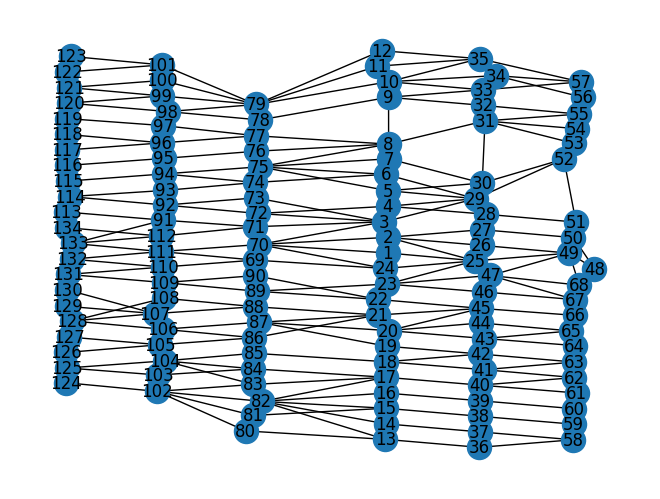

In [11]:
M = len(positions_by_id)

def is_north(cand, origin):
    cand_x, cand_y = cand
    origin_x, origin_y = origin
    dx = abs(cand_x - origin_x)
    dy = abs(cand_y - origin_y)
    return cand_y > origin_y and dy > dx

def is_west(cand, origin):
    cand_x, cand_y = cand
    origin_x, origin_y = origin
    dx = abs(cand_x - origin_x)
    dy = abs(cand_y - origin_y)
    return cand_x < origin_x and dx > dy

def is_east(cand, origin):
    cand_x, cand_y = cand
    origin_x, origin_y = origin
    dx = abs(cand_x - origin_x)
    dy = abs(cand_y - origin_y)
    return cand_x > origin_x and dx > dy

def is_south(cand, origin):
    cand_x, cand_y = cand
    origin_x, origin_y = origin
    dx = abs(cand_x - origin_x)
    dy = abs(cand_y - origin_y)
    return cand_y < origin_y and dy > dx

def find_best(origin_id, origin, filter):
    best_id = None
    best_dist = 1e18
    for id, cand in positions_by_id.items():
        dist = math.hypot(origin[0] - cand[0], origin[1] - cand[1])
        if id != origin_id and filter(cand, origin) and dist < best_dist:
            best_dist = dist
            best_id = id
    return best_id

G = nx.Graph()
for id, origin in positions_by_id.items():
    for filter in [is_north, is_west, is_east, is_south]:
        best_id = find_best(id, origin, filter)
        if best_id is not None:
            G.add_edge(id, best_id)

print(G.number_of_edges())
labels = {}
for id, pos in positions_by_id.items():
    labels[id] = f"{id+1}"
nx.draw(G, pos=positions_by_id, labels=labels)

In [12]:
class Imputer:

    vis_limit: int
    vis_count: int

    def __init__(self, model_pred, model_weight, vis_limit=10):
        self.vis_limit = vis_limit
        self.model_pred = model_pred
        self.model_weight = model_weight

    def expand_dir(self, tm, tm_dt, neighbor, target, visited, queue, tgt, level):
        key = (tm_dt, level, neighbor)
        z_src = tm_dt + ST
        for _ in range(level):
            z_src //= 2
        if CNT[z_src][neighbor] > 0 and Z[z_src][neighbor][-1] > -90 and key not in visited:
            visited.add(key)
            feature_v = features(Z[z_src][neighbor], target, tm, tm_dt, neighbor, tgt, level)
            X_chosen = feature_v[:-1]
            w = self.model_weight(X_chosen).item()
            v = self.model_pred(X_chosen).item()
            if self.vis_count < self.vis_limit and w > 0:
                self.vis_count += 1
                heapq.heappush(queue, (-w,v,tm_dt,level,neighbor))

    def expand(self, tm, node, target, visited, queue, level):
        for dt in [-1, 1]:
            tm_dt = tm + dt
            if tm_dt >= ST and tm_dt < SZ:
                self.expand_dir(tm, tm_dt, node, target, visited, queue, node, level)
        if level < L:
            self.expand_dir(tm, tm, node, target, visited, queue, node, level+1)
        for neighbor in G.adj[node]:
            self.expand_dir(tm, tm, neighbor, target, visited, queue, node, level)

    def predict(self, tm, node):
        self.vis_count = 0
        visited = set()
        visited.add((tm, 0, node))
        target = Z[tm][node]
        queue = []
        self.expand(tm, node, target, visited, queue, 0)

        parts = []
        while len(queue) > 0:
            neg_w, v, tm_loc, lev_loc, node_loc = heapq.heappop(queue)
            w = -neg_w
            parts.append([w,v])
            self.expand(tm_loc, node_loc, target, visited, queue, lev_loc)
        arr = np.array(parts)
        if len(arr) == 0:
            return 0
        pred = np.sum(arr[:,0] * arr[:,1]) / np.sum(arr[:,0])
        return pred

In [13]:
t_mask = None
n_mask = None

def mask_random(Z, ratio = 0.01):
    global t_mask, n_mask
    size = int(T * N * ratio)
    t_mask = np.random.randint(ST, ST+T, size=size)
    n_mask = np.random.randint(0, N, size=size)
    Z[t_mask,n_mask,-1] = -100

def mask_blackout(Z, minutes=30, ratio=0.01):
    global t_mask, n_mask
    size = int(T * N * ratio)
    cnt = minutes // 10
    n = size // cnt
    placed = torch.zeros((SZ, N), dtype=torch.bool, device='cpu')
    t_mask = np.zeros((n*cnt), dtype=int)
    n_mask = np.zeros((n*cnt), dtype=int)
    i = 0
    while n > 0:
        turbine = random.randint(0,N-1)
        t = random.randint(ST, T+ST-cnt-1)
        if torch.sum(placed[t:t+cnt,turbine]) > 0:
            continue
        Z[t:t+cnt,turbine,-1] = -100
        placed[t:t+cnt+cnt//2,turbine] = True
        t_mask[i:i+cnt] = t
        n_mask[i:i+cnt] = turbine
        n -= 1
        i += cnt

In [14]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_squared_error, median_absolute_error
import time

class Experiment(Enum):
    RANDOM = "random"
    BLACKOUT = "blackout"
    MAINTENANCE = "maintenance"

ratio = 0.01
experiments = [
    (Experiment.RANDOM, None),
    (Experiment.BLACKOUT, 30),
    (Experiment.BLACKOUT, 60),
    (Experiment.BLACKOUT, 150),
    (Experiment.BLACKOUT, 300),
    (Experiment.MAINTENANCE, 1),
    (Experiment.MAINTENANCE, 2),
    (Experiment.MAINTENANCE, 7),
    (Experiment.MAINTENANCE, 14),
]

results = []
for experiment, size in experiments:
    print(f"Running experiment {experiment} with size {size}")

    mask_fn = None
    if experiment == Experiment.RANDOM:
        mask_fn = functools.partial(mask_random, ratio=ratio)
    if experiment == Experiment.BLACKOUT:
        mask_fn = functools.partial(mask_blackout, ratio=ratio, minutes=size)
    if experiment == Experiment.MAINTENANCE:
        mask_fn = functools.partial(mask_blackout, ratio=ratio, minutes=size*60*24)
    
    get_Z(mask_fn)
    print("Generated masked data")

    tb = test_batch(10)
    in_features = tb.shape[1]-1
    model_pred = Model(in_features, 128, 64, 1)
    train_start = time.time()
    optimizer_pred = optim.Adam(model_pred.parameters(), lr=1e-3)
    train(model_pred, optimizer_pred, epochs=20, repeats=1, sampling_stddev=5)
    model_pred.eval()
    print("Trained prediction model")

    in_features = tb.shape[1]-1
    model_weight = Model(in_features, 128, 64, 1)
    optimizer_weight = optim.Adam(model_weight.parameters(), lr=1e-3)
    train2(model_pred, model_weight, optimizer_weight, epochs=10)
    train_time = time.time() - train_start
    model_weight.eval()
    print(f"All training complete in {train_time} seconds")

    imputer = Imputer(model_pred, model_weight, vis_limit=10)
    valids = X[t_mask-ST,n_mask,-1] > -90
    tmsk = t_mask[valids.cpu().numpy()]
    nmsk = n_mask[valids.cpu().numpy()]
    preds = []
    trues = []

    limit = 1000
    eval_start = time.time()
    eval_idxs = np.random.choice(np.arange(0, T), size=limit, replace=False)
    for i, (t, n) in tqdm(enumerate(zip(tmsk[eval_idxs], nmsk[eval_idxs]))):
        preds.append(imputer.predict(t-ST, n))
        trues.append(X[t-ST, n, -1].cpu().numpy())
    eval_time = time.time() - eval_start
    print(f"Time to impute {limit} distinct values: {eval_time}")

    preds = np.array(preds)
    trues = np.array(trues)
    mse = mean_squared_error(trues, preds)
    mae = mean_absolute_error(trues, preds)
    rmse = root_mean_squared_error(trues, preds)
    medae = median_absolute_error(trues, preds)

    print(f"MSE: {mse}, MAE: {mae}, RMSE: {rmse}, MEDAE: {medae}")
    results.append({
        "experiment": experiment,
        "size": size,
        "mse": mse,
        "mae": mae,
        "rmse": rmse,
        "medae": medae,
        "train_time": train_time,
        "eval_time": eval_time,
    })
    df = pd.DataFrame(data=results)
    df.to_csv("main_method_results.csv")

Running experiment Experiment.RANDOM with size None
Generated masked data
Model loaded on cuda for training.
Trained prediction model
Model loaded on cuda for training.


/home/beni/windfarm_data_imputation/.venv/lib/python3.12/site-packages/torch/_tensor.py:1002: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


All training complete in 150.5941503047943 seconds


1000it [01:01, 16.33it/s]


Time to impute 1000 distinct values: 61.22332763671875
MSE: 0.006998339029037902, MAE: 0.050161422823629974, RMSE: 0.08365607586444575, MEDAE: 0.024005723126107548
Running experiment Experiment.BLACKOUT with size 30
Generated masked data
Model loaded on cuda for training.
Trained prediction model
Model loaded on cuda for training.


/home/beni/windfarm_data_imputation/.venv/lib/python3.12/site-packages/torch/_tensor.py:1002: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


All training complete in 141.41641449928284 seconds


1000it [00:56, 17.57it/s]


Time to impute 1000 distinct values: 56.91307067871094
MSE: 0.007910919194822875, MAE: 0.05494592577810119, RMSE: 0.08894334823258497, MEDAE: 0.031823523853442705
Running experiment Experiment.BLACKOUT with size 60
Generated masked data
Model loaded on cuda for training.
Trained prediction model
Model loaded on cuda for training.


/home/beni/windfarm_data_imputation/.venv/lib/python3.12/site-packages/torch/_tensor.py:1002: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


All training complete in 143.98143315315247 seconds


1000it [00:57, 17.44it/s]


Time to impute 1000 distinct values: 57.3570339679718
MSE: 0.010038394916517462, MAE: 0.05582681020930531, RMSE: 0.10019179066429276, MEDAE: 0.027285690400096218
Running experiment Experiment.BLACKOUT with size 150
Generated masked data
Model loaded on cuda for training.
Trained prediction model
Model loaded on cuda for training.


/home/beni/windfarm_data_imputation/.venv/lib/python3.12/site-packages/torch/_tensor.py:1002: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


All training complete in 141.69838309288025 seconds


1000it [00:59, 16.86it/s]


Time to impute 1000 distinct values: 59.307769536972046
MSE: 0.009858353227807275, MAE: 0.05970732393753454, RMSE: 0.09928924024186747, MEDAE: 0.03361952924868121
Running experiment Experiment.BLACKOUT with size 300
Generated masked data
Model loaded on cuda for training.
Trained prediction model
Model loaded on cuda for training.


/home/beni/windfarm_data_imputation/.venv/lib/python3.12/site-packages/torch/_tensor.py:1002: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


All training complete in 145.14478468894958 seconds


1000it [00:56, 17.81it/s]


Time to impute 1000 distinct values: 56.152148962020874
MSE: 0.008842400191430745, MAE: 0.06445318875710332, RMSE: 0.09403403740896561, MEDAE: 0.041698438594228365
Running experiment Experiment.MAINTENANCE with size 1
Generated masked data
Model loaded on cuda for training.
Trained prediction model
Model loaded on cuda for training.


/home/beni/windfarm_data_imputation/.venv/lib/python3.12/site-packages/torch/_tensor.py:1002: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


All training complete in 141.5803735256195 seconds


1000it [00:57, 17.48it/s]


Time to impute 1000 distinct values: 57.221694231033325
MSE: 0.01012864387767991, MAE: 0.05718959599689331, RMSE: 0.10064116393245812, MEDAE: 0.03169540427035872
Running experiment Experiment.MAINTENANCE with size 2
Generated masked data
Model loaded on cuda for training.
Trained prediction model
Model loaded on cuda for training.


/home/beni/windfarm_data_imputation/.venv/lib/python3.12/site-packages/torch/_tensor.py:1002: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


All training complete in 141.39214944839478 seconds


1000it [00:07, 131.26it/s]


Time to impute 1000 distinct values: 7.621175050735474
MSE: 0.12703074514865875, MAE: 0.22384503483772278, RMSE: 0.35641372203826904, MEDAE: 0.10319091379642487
Running experiment Experiment.MAINTENANCE with size 7
Generated masked data
Model loaded on cuda for training.
Trained prediction model
Model loaded on cuda for training.


/home/beni/windfarm_data_imputation/.venv/lib/python3.12/site-packages/torch/_tensor.py:1002: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


All training complete in 135.90089297294617 seconds


1000it [00:57, 17.49it/s]


Time to impute 1000 distinct values: 57.18575930595398
MSE: 0.002878860969485561, MAE: 0.0376849391366791, RMSE: 0.05365501812026123, MEDAE: 0.02433520084620974
Running experiment Experiment.MAINTENANCE with size 14
Generated masked data
Model loaded on cuda for training.
Trained prediction model
Model loaded on cuda for training.


/home/beni/windfarm_data_imputation/.venv/lib/python3.12/site-packages/torch/_tensor.py:1002: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


All training complete in 144.80208110809326 seconds


1000it [01:06, 15.03it/s]

Time to impute 1000 distinct values: 66.522292137146
MSE: 0.004218142010823166, MAE: 0.04300612197396308, RMSE: 0.06494722481232872, MEDAE: 0.030103777204395388
